## Data description

"Ministère de l'Environnement et de la Lutte contre les changements climatiques (MELCC)", 
2021. 

Physicochemical monitoring of rivers and rivers from 2000 to 2020, Quebec, Direction 
general monitoring of the state of the environment.

Metadata

https://www.donneesquebec.ca/recherche/dataset/bf2ca474-b331-4d35-ad09-351ca8f89b27/resource/cdc52e3c-0056-4d39-bbf7-f5804699cb5f/download/donneesquebec_physicochimie.pdf

Data source: 
https://www.donneesquebec.ca/recherche/dataset/suivi-physicochimique-des-rivieres-et-du-fleuve


## Import library

In [308]:
import os
import sys

import geopandas as gpd
import fiona as fiona
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import scipy.stats as stats

%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Pour la reproductibilité des résultats
np.random.seed(43)
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

sns.set(rc={'figure.figsize':(8, 6)})
sns.set_theme(context="notebook", style="white", palette="pastel",font_scale=0.9)

## Load data

In [3]:
#read the geospatial data
f = r'D:\Daiana\Documents\AEC Intelligence artificielle\Hackathon 2 IA\data\physicochimie_2000_2020_json\AD_physicochimie_WGS84.json'
ff=r'D:\Daiana\Documents\AEC Intelligence artificielle\Hackathon 2 IA\data\physicochimie_2000_2020_json\IQBP_WGS84.json'
gdf=gpd.read_file(f)
gdf2=gpd.read_file(ff)

## Exploratory data analysis

In [4]:
gdf.head()

OBJECTID NO_STATION  SUPERF_QC_KM2  SUPERF_TOT_KM2 FRONTIERE  PC_AGRICOLE  \
0      1263   04310002        93683.0        143159.3        ON         2.48   
1      1264   06290002        79865.6         79865.6      None         2.03   
2      1265   06290013        72944.4         72944.4      None         1.91   
3      1266   06290012        72773.5         72773.5      None         1.80   
4      1267   07110001        46018.0         46018.0      None         0.00   

   PC_FORESTIER  PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
0         69.37      11.87         11.41            0.95   
1         55.31      15.13          9.50            0.58   
2         54.16      15.37          9.74            0.42   
3         54.22      15.38          9.76            0.40   
4         62.95       9.65         13.21            0.23   

   PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
0                   3.69                0              0.05      2018   
1                  15.91                0              0.04      2018   
2                  16.71                0              0.04      2018   
3                  16.74                0              0.04      2018   
4                   8.63                0              0.04      2018   

   Shape_Length    Shape_Area  \
0  6.038883e+06  3.044166e+11   
1  4.057730e+06  1.916073e+11   
2  4.081420e+06  1.758983e+11   
3  4.091098e+06  1.755096e+11   
4  3.698174e+06  1.186076e+11   

                                            geometry  
0  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
1  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
2  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
3  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
4  POLYGON ((-7846546.645 6855279.980, -7846607.2...

In [5]:
gdf.geometry.head()

0    POLYGON ((-8330308.069 5668953.619, -8330255.7...
1    POLYGON ((-8017339.612 6645610.164, -8017380.9...
2    POLYGON ((-8017339.612 6645610.164, -8017380.9...
3    POLYGON ((-8017339.612 6645610.164, -8017380.9...
4    POLYGON ((-7846546.645 6855279.980, -7846607.2...
Name: geometry, dtype: geometry

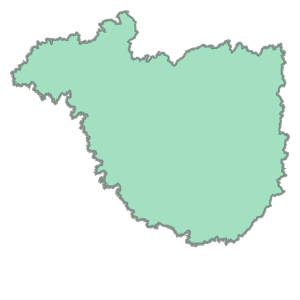

In [6]:
gdf['geometry'].iloc[0]

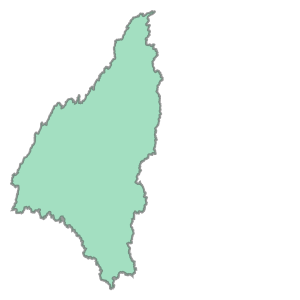

In [7]:
gdf.geometry.iloc[1]

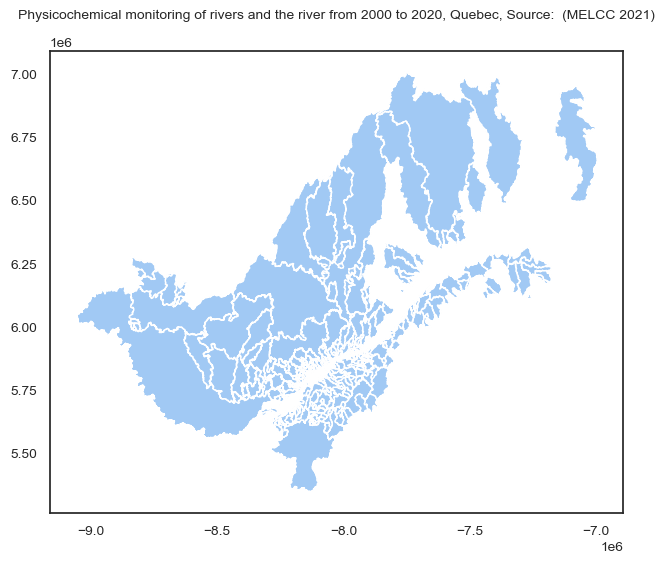

In [8]:
gdf.plot(figsize=(10,6))
plt.title("Physicochemical monitoring of rivers and the river from 2000 to 2020, Quebec, Source:  (MELCC 2021)"
          
          ,fontdict={'fontsize':10}, loc='center',y=1.05)
plt.show()

In [9]:
max_area=gdf.SUPERF_QC_KM2.max()
gdf[gdf.SUPERF_QC_KM2==max_area]

OBJECTID NO_STATION  SUPERF_QC_KM2  SUPERF_TOT_KM2 FRONTIERE  PC_AGRICOLE  \
0      1263   04310002        93683.0        143159.3        ON         2.48   

   PC_FORESTIER  PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
0         69.37      11.87         11.41            0.95   

   PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
0                   3.69                0              0.05      2018   

   Shape_Length    Shape_Area  \
0  6.038883e+06  3.044166e+11   

                                            geometry  
0  POLYGON ((-8330308.069 5668953.619, -8330255.7...

In [10]:
gdf2.head()

OBJECTID   NO_STAT           NomCoursEau  \
0         1  00000009  Fleuve Saint-Laurent   
1         2  00000072  Fleuve Saint-Laurent   
2         3  00000075  Fleuve Saint-Laurent   
3         4  00000077  Fleuve Saint-Laurent   
4         5  00000078  Fleuve Saint-Laurent   

                                            DESCRIPT       TYP_STAT TYP_SUIV  \
0                              SAINT-LAURENT À SOREL  Réseau-fleuve  12 mois   
1  CANAL DE BEAUHARNOIS AU PONT-ROUTE 132 À VALLE...  Réseau-fleuve  12 mois   
2  SAINT-LAURENT CHENAL DU SUD EN AMONT DE LA MAR...  Réseau-fleuve  12 mois   
3           SAINT-LAURENT À LA PRISE D'EAU DE LAUZON  Réseau-fleuve  12 mois   
4  SAINT-LAURENT À LA PRISE D'EAU DE MONTRÉAL (LA...  Réseau-fleuve  12 mois   

     STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PTOT_MED  PTOT_Q90  \
0  2000-05-07  2000-10-01       6         6  ...       NaN       NaN   
1  1998-05-03  2000-10-01      14        90  ...       NaN       NaN   
2  1998-05-04  2000-10-02      17        81  ...       NaN       NaN   
3  1998-05-04  2000-10-02      14        76  ...       NaN       NaN   
4  1998-06-09  2000-10-02      16        90  ...       NaN       NaN   

   URL_ZGIEBV                                         URL_ZGIESL        LAT  \
0        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  46.054539   
1        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.224068   
2        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.857759   
3        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  46.832805   
4        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.409040   

        LONG  NOM_ZGIEBV                            NOM_ZGIESL  ANNEE_FILTRE  \
0 -73.121283        None                      Lac Saint-Pierre          2000   
1 -74.115648        None  Haut-Saint-Laurent et Grand Montréal          2000   
2 -73.243911        None  Haut-Saint-Laurent et Grand Montréal          2000   
3 -71.151452        None                                Québec          2000   
4 -73.633272        None  Haut-Saint-Laurent et Grand Montréal          2000   

                           geometry  
0  POINT (-8139824.007 5789093.466)  
1  POINT (-8250516.228 5656865.712)  
2  POINT (-8153474.876 5757584.226)  
3  POINT (-7920543.417 5914826.230)  
4  POINT (-8196818.349 5686148.040)  

[5 rows x 37 columns]

<AxesSubplot:>

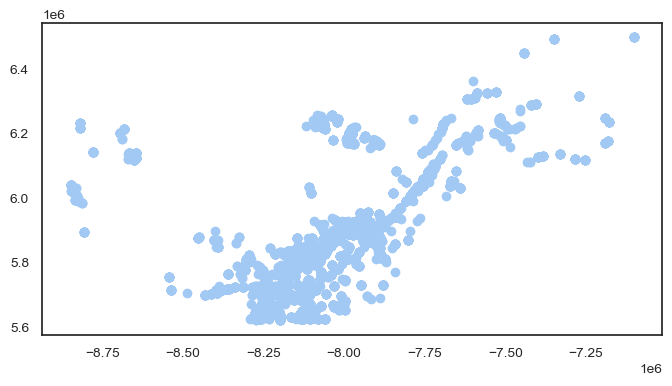

In [11]:
gdf2.plot(figsize=(8,6))

### Data set dimensions

#### Descriptive information – Physicochemical monitoring stations

In [12]:
print("Dimension of file Physicochemical monitoring stations")
print(gdf.shape)

Dimension of file Physicochemical monitoring stations
(402, 17)


##### Data type

In [13]:
gdf.describe()

OBJECTID  SUPERF_QC_KM2  SUPERF_TOT_KM2  PC_AGRICOLE  PC_FORESTIER  \
count   402.000000     402.000000      402.000000   402.000000    402.000000   
mean   1463.500000    2409.415672     2769.720647    27.226294     49.935199   
std     116.191652    9452.536412    11049.907623    26.387132     25.313104   
min    1263.000000       0.200000        0.300000     0.000000      0.000000   
25%    1363.250000      54.800000       61.925000     2.197500     27.825000   
50%    1463.500000     210.950000      219.550000    19.380000     53.725000   
75%    1563.750000    1021.625000     1051.225000    46.622500     73.437500   
max    1664.000000   93683.000000   143159.300000    97.270000     96.590000   

        PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  PC_COUPE_REGENERATION  \
count  402.000000     402.00000      402.000000             402.000000   
mean    10.529900       2.84209        6.992438               2.195622   
std      9.435413       3.51852       12.417395               3.499013   
min      0.000000       0.00000        0.000000               0.000000   
25%      5.115000       0.28250        1.430000               0.170000   
50%      7.845000       1.08000        3.500000               0.900000   
75%     12.287500       4.36000        7.452500               2.577500   
max     69.710000      16.43000       97.330000              22.430000   

       PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  Shape_Length    Shape_Area  
count            402.0        402.000000     402.0  4.020000e+02  4.020000e+02  
mean               0.0          0.010970    2018.0  3.688422e+05  6.189050e+09  
std                0.0          0.023408       0.0  6.926430e+05  2.496761e+10  
min                0.0          0.000000    2018.0  4.876538e+03  5.893369e+05  
25%                0.0          0.000000    2018.0  6.500731e+04  1.307031e+08  
50%                0.0          0.000000    2018.0  1.440616e+05  4.715858e+08  
75%                0.0          0.010000    2018.0  3.480960e+05  2.304659e+09  
max                0.0          0.330000    2018.0  6.038883e+06  3.044166e+11

#### Descriptive information-Drainage areas of physicochemical monitoring stations

In [14]:
print("Dimension of file Drainage areas of physicochemical monitoring stations")
print(gdf2.shape)

Dimension of file Drainage areas of physicochemical monitoring stations
(5998, 37)


##### Data type

In [15]:
gdf2.describe()

OBJECTID       IQBP_N     IQBP_MED   IQBP_CLASS        NH3_N  \
count  5998.000000  5998.000000  5998.000000  5998.000000  5956.000000   
mean   2999.500000    15.912137    60.007836     2.452317    16.776528   
std    1731.617789     5.431685    28.142384     1.370006     7.669009   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%    1500.250000    15.000000    40.000000     1.000000    16.000000   
50%    2999.500000    17.000000    67.000000     2.000000    17.000000   
75%    4498.750000    18.000000    85.000000     3.000000    18.000000   
max    5998.000000    70.000000    98.000000     5.000000    79.000000   

           NH3_MED      NH3_Q90       CHLA_N     CHLA_MED     CHLA_Q90  ...  \
count  5956.000000  5956.000000  5896.000000  5896.000000  5896.000000  ...   
mean      0.034354     0.092112    16.054274     2.775989     7.494454  ...   
std       0.063791     0.187675     5.264644     3.023807    10.701820  ...   
min       0.002000     0.005000     1.000000     0.110000     0.150000  ...   
25%       0.010000     0.030000    15.000000     1.350000     2.334750  ...   
50%       0.020000     0.049000    17.000000     2.072500     4.071500  ...   
75%       0.040000     0.089000    18.000000     3.300000     8.461250  ...   
max       2.100000     5.620000    67.000000   120.000000   222.700000  ...   

           MES_MED      MES_Q90        NOX_N      NOX_MED      NOX_Q90  \
count  5956.000000  5956.000000  5956.000000  5956.000000  5956.000000   
mean      8.139506    25.877099    16.943251     0.534610     1.116984   
std      10.906780    43.918687     7.950337     0.808483     1.833754   
min       0.500000     0.000000     1.000000     0.010000     0.010000   
25%       2.500000     7.000000    16.000000     0.105000     0.178000   
50%       5.000000    14.000000    17.000000     0.240000     0.379000   
75%       9.500000    28.250000    18.000000     0.610000     1.230000   
max     205.000000  1628.000000    79.000000    10.000000    30.400000   

            PTOT_N     PTOT_MED     PTOT_Q90          LAT         LONG  
count  4187.000000  4187.000000  4187.000000  5998.000000  5998.000000  
mean     16.714115     0.043098     0.087535    46.501632   -72.401316  
std       9.577291     0.075782     0.136297     1.094142     2.249383  
min       1.000000     0.001000     0.001000    44.992240   -79.484222  
25%      12.000000     0.011000     0.020000    45.655441   -73.450222  
50%      17.000000     0.021000     0.042000    46.308958   -72.537659  
75%      18.000000     0.052000     0.107000    46.855832   -71.348189  
max      79.000000     2.700000     2.700000    50.306360   -63.786856  

[8 rows x 24 columns]

In [16]:
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      5998 non-null   int64   
 1   NO_STAT       5998 non-null   object  
 2   NomCoursEau   5998 non-null   object  
 3   DESCRIPT      5998 non-null   object  
 4   TYP_STAT      5998 non-null   object  
 5   TYP_SUIV      5998 non-null   object  
 6   STAT_DEB      5998 non-null   object  
 7   STAT_FIN      5998 non-null   object  
 8   IQBP_N        5998 non-null   int64   
 9   IQBP_MED      5998 non-null   int64   
 10  IQBP_CLASS    5998 non-null   int64   
 11  NH3_N         5956 non-null   float64 
 12  NH3_MED       5956 non-null   float64 
 13  NH3_Q90       5956 non-null   float64 
 14  CHLA_N        5896 non-null   float64 
 15  CHLA_MED      5896 non-null   float64 
 16  CHLA_Q90      5896 non-null   float64 
 17  CF_N          5955 non-null   float64 
 18  

#### Merge files

In [17]:
gdf2[gdf2.NO_STATION  =="04310002"].tail()

AttributeError: 'GeoDataFrame' object has no attribute 'NO_STATION'

In [18]:
gdf2.rename(columns={'NO_STAT': "NO_STATION"},inplace=True)

In [19]:
df = pd.merge(gdf2,gdf,on='NO_STATION', how='left')


In [20]:
df.describe()

OBJECTID_x       IQBP_N     IQBP_MED   IQBP_CLASS        NH3_N  \
count  5998.000000  5998.000000  5998.000000  5998.000000  5956.000000   
mean   2999.500000    15.912137    60.007836     2.452317    16.776528   
std    1731.617789     5.431685    28.142384     1.370006     7.669009   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%    1500.250000    15.000000    40.000000     1.000000    16.000000   
50%    2999.500000    17.000000    67.000000     2.000000    17.000000   
75%    4498.750000    18.000000    85.000000     3.000000    18.000000   
max    5998.000000    70.000000    98.000000     5.000000    79.000000   

           NH3_MED      NH3_Q90       CHLA_N     CHLA_MED     CHLA_Q90  ...  \
count  5956.000000  5956.000000  5896.000000  5896.000000  5896.000000  ...   
mean      0.034354     0.092112    16.054274     2.775989     7.494454  ...   
std       0.063791     0.187675     5.264644     3.023807    10.701820  ...   
min       0.002000     0.005000     1.000000     0.110000     0.150000  ...   
25%       0.010000     0.030000    15.000000     1.350000     2.334750  ...   
50%       0.020000     0.049000    17.000000     2.072500     4.071500  ...   
75%       0.040000     0.089000    18.000000     3.300000     8.461250  ...   
max       2.100000     5.620000    67.000000   120.000000   222.700000  ...   

       PC_FORESTIER    PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
count   4457.000000  4457.000000   4457.000000     4457.000000   
mean      52.260738    11.025961      3.514039        5.124249   
std       24.187421     9.016509      3.680354        7.243089   
min        0.000000     0.000000      0.000000        0.000000   
25%       31.070000     5.720000      0.530000        1.320000   
50%       56.530000     8.460000      1.950000        3.350000   
75%       74.570000    12.300000      5.800000        5.820000   
max       96.590000    69.710000     16.430000       97.330000   

       PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
count            4457.000000           4457.0       4457.000000    4457.0   
mean                2.547552              0.0          0.013211    2018.0   
std                 3.700841              0.0          0.022690       0.0   
min                 0.000000              0.0          0.000000    2018.0   
25%                 0.270000              0.0          0.000000    2018.0   
50%                 1.430000              0.0          0.010000    2018.0   
75%                 2.910000              0.0          0.020000    2018.0   
max                22.430000              0.0          0.330000    2018.0   

       Shape_Length    Shape_Area  
count  4.457000e+03  4.457000e+03  
mean   5.184329e+05  9.790854e+09  
std    8.344223e+05  3.258204e+10  
min    4.876538e+03  5.893369e+05  
25%    1.097282e+05  3.325041e+08  
50%    2.390749e+05  1.107366e+09  
75%    4.829495e+05  3.552380e+09  
max    6.038883e+06  3.044166e+11  

[8 rows x 38 columns]

In [21]:
df[df.NO_STATION=="04310002"].head()

OBJECTID_x NO_STATION            NomCoursEau  \
130         131   04310002  Rivière des Outaouais   
324         325   04310002  Rivière des Outaouais   
527         528   04310002  Rivière des Outaouais   
737         738   04310002  Rivière des Outaouais   
942         943   04310002  Rivière des Outaouais   

                                              DESCRIPT         TYP_STAT  \
130  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
324  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
527  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
737  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
942  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   

    TYP_SUIV    STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PC_HUMIDE  \
130  12 mois  1998-05-18  2000-10-09      15        85  ...      11.87   
324  12 mois  1999-05-10  2001-10-21      15        85  ...      11.87   
527  12 mois  2000-05-14  2002-10-14      16        85  ...      11.87   
737  12 mois  2001-05-14  2003-10-13      18        85  ...      11.87   
942  12 mois  2002-05-12  2004-10-11      17        79  ...      11.87   

     PC_AQUATIQUE  PC_ANTHROPIQUE  PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  \
130         11.41            0.95                   3.69              0.0   
324         11.41            0.95                   3.69              0.0   
527         11.41            0.95                   3.69              0.0   
737         11.41            0.95                   3.69              0.0   
942         11.41            0.95                   3.69              0.0   

     PC_NON_CLASSIFIE  ANNEE_UT  Shape_Length    Shape_Area  \
130              0.05    2018.0  6.038883e+06  3.044166e+11   
324              0.05    2018.0  6.038883e+06  3.044166e+11   
527              0.05    2018.0  6.038883e+06  3.044166e+11   
737              0.05    2018.0  6.038883e+06  3.044166e+11   
942              0.05    2018.0  6.038883e+06  3.044166e+11   

                                            geometry_y  
130  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
324  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
527  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
737  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
942  POLYGON ((-8330308.069 5668953.619, -8330255.7...  

[5 rows x 53 columns]

In [22]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5998 entries, 0 to 5997
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID_x             5998 non-null   int64   
 1   NO_STATION             5998 non-null   object  
 2   NomCoursEau            5998 non-null   object  
 3   DESCRIPT               5998 non-null   object  
 4   TYP_STAT               5998 non-null   object  
 5   TYP_SUIV               5998 non-null   object  
 6   STAT_DEB               5998 non-null   object  
 7   STAT_FIN               5998 non-null   object  
 8   IQBP_N                 5998 non-null   int64   
 9   IQBP_MED               5998 non-null   int64   
 10  IQBP_CLASS             5998 non-null   int64   
 11  NH3_N                  5956 non-null   float64 
 12  NH3_MED                5956 non-null   float64 
 13  NH3_Q90                5956 non-null   float64 
 14  CHLA_N                 5896 non-

Rivière des Outaouais


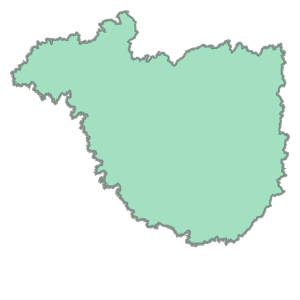

In [23]:
print(df.NomCoursEau.iloc[130])
df.geometry_y.iloc[130]

In [24]:
#lister les  occurences de chacune des occurences non-numériques
for key in df.select_dtypes(exclude='number').columns:
    print("\n---- %s ----" % key)
    print(df[key].value_counts())


---- NO_STATION ----
06290002    21
04040001    21
03090009    21
03090046    21
03090047    21
            ..
02310051     1
02200055     1
06G06001     1
06340001     1
07A30001     1
Name: NO_STATION, Length: 856, dtype: int64

---- NomCoursEau ----
Fleuve Saint-Laurent      617
Rivière Yamaska           111
Rivière du Loup           110
Rivière Saint-François    109
Rivière Chaudière         105
                         ... 
Rivière Kempt               1
Rivière des Sept Îles       1
Rivière Milky               1
Rivière Du Bas De Soie      1
Rivière à la Truite         1
Name: NomCoursEau, Length: 403, dtype: int64

---- DESCRIPT ----
SAINT-LAURENT SOUS LE PONT LAVIOLETTE À TROIS-RIVIÈRES (RIVE NORD)                                     22
SAINT-LAURENT ENTRE REPENTIGNY ET VARENNES (RIVE NORD,VOIE MARITIME)                                   22
SAINT-LAURENT AU PORT DE BÉCANCOUR (RIVE SUD)                                                          22
CHÂTEAUGUAY À GUÉ À 1,6 KM EN AVA

AttributeError: 'GeometryArray' object has no attribute 'value_counts'

### Data visualization

In [25]:
df.columns

Index(['OBJECTID_x', 'NO_STATION', 'NomCoursEau', 'DESCRIPT', 'TYP_STAT',
       'TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE', 'geometry_x',
       'OBJECTID_y', 'SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT', 'Shape_Length', 'Shape_Area',
       'geometry_y'],
      dtype='object')

In [26]:
features=['NO_STATION', 'NomCoursEau','TYP_STAT','TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE','SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT']

#### Year

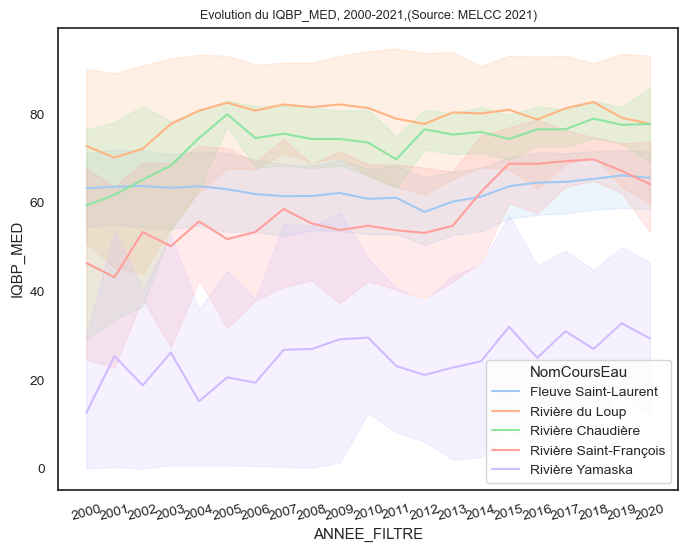

In [27]:
filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
sns.lineplot(data=df[filter_cours], 
             x="ANNEE_FILTRE", 
             y='IQBP_MED',
             hue='NomCoursEau',
             markers=True,
             dashes=False)

plt.title(label='Evolution du IQBP_MED, 2000-2021,(Source: MELCC 2021)',fontdict={'fontsize':9}, loc='center')
plt.xticks(rotation=15)
plt.show()

* Median value of the bacteriological quality index and 
physicochemical of water. IQBP classifies water quality into five classes 
on a scale from 0 (very poor quality) to 100 (good quality)

* It is based on five parameters: total phosphorus, faecal coliforms, ammoniacal nitrogen, nitrite nitrates and active chlorophyll a.

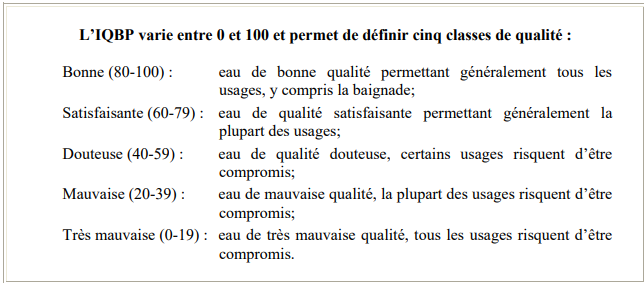

https://mddep.gouv.qc.ca/eau/eco_aqua/suivi_mil-aqua/indice-qualite-bacteriologique-physicochimique.htm

In [28]:
df.IQBP_CLASS.unique()

array([5, 1, 2, 3, 4], dtype=int64)

In [29]:
filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
df[filter_cours][["ANNEE_FILTRE","IQBP_CLASS","NomCoursEau","IQBP_MED"]]

ANNEE_FILTRE  IQBP_CLASS           NomCoursEau  IQBP_MED
0            2000           5  Fleuve Saint-Laurent         6
1            2000           1  Fleuve Saint-Laurent        90
2            2000           1  Fleuve Saint-Laurent        81
3            2000           2  Fleuve Saint-Laurent        76
4            2000           1  Fleuve Saint-Laurent        90
...           ...         ...                   ...       ...
5788         2020           4       Rivière Yamaska        27
5789         2020           3       Rivière Yamaska        58
5938         2020           3       Rivière du Loup        48
5939         2020           1       Rivière du Loup        91
5940         2020           1       Rivière du Loup        95

[1052 rows x 4 columns]

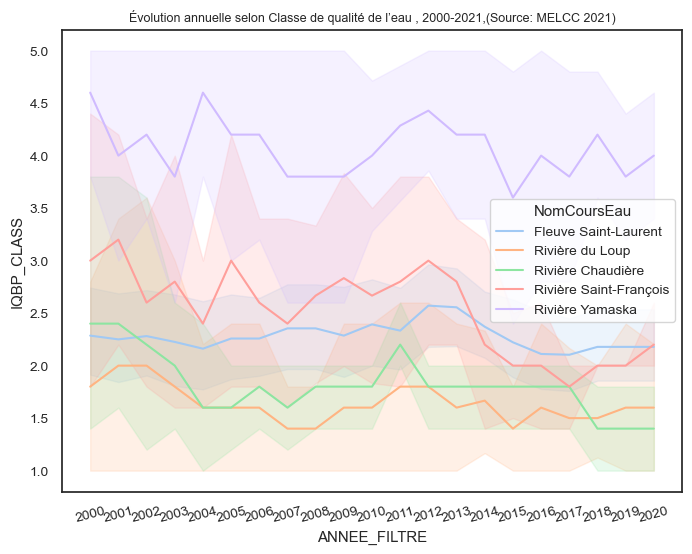

In [30]:
filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
sns.lineplot(data=df[filter_cours], 
             x="ANNEE_FILTRE", 
             y='IQBP_CLASS',
             hue='NomCoursEau',
             markers=True,
             dashes=False)

plt.title(label='Évolution annuelle selon Classe de qualité de l’eau , 2000-2021,(Source: MELCC 2021)',fontdict={'fontsize':9}, loc='center')
plt.xticks(rotation=15)
plt.show()

The Yamaska River has the poor water quality with a classification index between 4 and 4.5(,median between 20-39 ).
A increase of 0.5 points is noted for the Chaudière River which goes from 2.0 to 1.5.

In [31]:
dfg=gpd.GeoDataFrame(df)

In [32]:
filter_cours=df.NomCoursEau.isin(["Rivière Chaudière"])
df[filter_cours]

OBJECTID_x NO_STATION        NomCoursEau  \
47            48   02340004  Rivière Chaudière   
48            49   02340006  Rivière Chaudière   
49            50   02340014  Rivière Chaudière   
50            51   02340033  Rivière Chaudière   
52            53   02340050  Rivière Chaudière   
...          ...        ...                ...   
5726        5727   02340004  Rivière Chaudière   
5727        5728   02340006  Rivière Chaudière   
5728        5729   02340014  Rivière Chaudière   
5729        5730   02340033  Rivière Chaudière   
5732        5733   02340050  Rivière Chaudière   

                                               DESCRIPT         TYP_STAT  \
47    CHAUDIÈRE AU PONT COUVERT PERREAULT À NOTRE-DA...  Réseau-rivières   
48    CHAUDIÈRE AU PONT DU CHEMIN DU LAC DROLET AU S...  Réseau-rivières   
49    CHAUDIÈRE AU PONT-ROUTE 171 À SCOTT, À L'OUEST...  Réseau-rivières   
50    CHAUDIÈRE À 5,6 KM DE L'EMBOUCHURE À LA PRISE ...  Réseau-rivières   
52    CHAUDIÈRE AU PONT-ROUTE 132 À SAINT-ROMUALD À ...            Autre   
...                                                 ...              ...   
5726  CHAUDIÈRE AU PONT COUVERT PERREAULT À NOTRE-DA...  Réseau-rivières   
5727  CHAUDIÈRE AU PONT DU CHEMIN DU LAC DROLET AU S...  Réseau-rivières   
5728  CHAUDIÈRE AU PONT-ROUTE 171 À SCOTT, À L'OUEST...  Réseau-rivières   
5729  CHAUDIÈRE À 5,6 KM DE L'EMBOUCHURE À LA PRISE ...  Réseau-rivières   
5732  CHAUDIÈRE AU PONT-ROUTE 132 À SAINT-ROMUALD À ...  Réseau-rivières   

     TYP_SUIV    STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PC_HUMIDE  \
47     8 mois  1998-05-03  2000-10-01      13        80  ...      11.73   
48     8 mois  1998-05-03  2000-10-02      17        71  ...       8.58   
49     8 mois  1998-05-04  2000-10-02      16        74  ...      10.20   
50    12 mois  1998-05-04  2000-10-02      12        72  ...      12.06   
52     8 mois  2000-05-11  2000-10-12       4         0  ...      12.16   
...       ...         ...         ...     ...       ...  ...        ...   
5726   8 mois  2018-06-06  2020-10-06      12        71  ...      11.73   
5727   8 mois  2018-05-07  2020-10-13      15        89  ...       8.58   
5728   8 mois  2018-05-15  2020-10-06      14        86  ...      10.20   
5729  12 mois  2018-05-07  2020-10-05      14        80  ...      12.06   
5732   8 mois  2018-05-10  2020-10-08      16        63  ...      12.16   

      PC_AQUATIQUE  PC_ANTHROPIQUE  PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  \
47            1.98            2.78                   2.23              0.0   
48            4.02            2.49                   2.71              0.0   
49            1.63            3.31                   1.71              0.0   
50            1.58            3.60                   1.72              0.0   
52            1.58            3.86                   1.71              0.0   
...            ...             ...                    ...              ...   
5726          1.98            2.78                   2.23              0.0   
5727          4.02            2.49                   2.71              0.0   
5728          1.63            3.31                   1.71              0.0   
5729          1.58            3.60                   1.72              0.0   
5732          1.58            3.86                   1.71              0.0   

      PC_NON_CLASSIFIE  ANNEE_UT  Shape_Length    Shape_Area  \
47                0.01    2018.0  7.131442e+05  8.422757e+09   
48                0.01    2018.0  3.058682e+05  2.312530e+09   
49                0.01    2018.0  9.005079e+05  1.184614e+10   
50                0.01    2018.0  1.072660e+06  1.373829e+10   
52                0.01    2018.0  1.084491e+06  1.385462e+10   
...                ...       ...           ...           ...   
5726              0.01    2018.0  7.131442e+05  8.422757e+09   
5727              0.01    2018.0  3.058682e+05  2.312530e+09   
5728              0.01    2018.0  9.005079e+05  1.184614e+10   
5729          

Rivière Chaudière(Source: MELCC 2021)


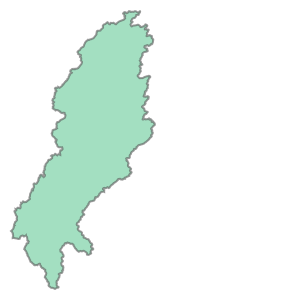

In [33]:
print('Rivière Chaudière(Source: MELCC 2021)')
dfg[filter_cours]['geometry_y'].iloc[50]

#plt.show()

In [34]:
dfChaudiere=pd.read_excel(dfg.iloc[5729]["URL_ZGIEBV"],sheet_name='Données brutes')

In [35]:
dfChaudiere.dropna()

N° PROJET  N° STATION       DATE   HEURE LABO ABRÉVIATION  \
5         210.0   2340004.0 2018-04-10  1315.0  DLQ         NH3   
48        210.0   2340004.0 2018-10-09  1115.0  DLQ         NH3   
62        210.0   2340004.0 2018-11-06  1343.0  DLQ         NH3   
176       210.0   2340004.0 2019-10-16  1410.0  DLQ         NH3   
258       210.0   2340004.0 2020-09-08   845.0  DLQ     P-D-PER   
...         ...         ...        ...     ...  ...         ...   
2771      210.0   2340051.0 2019-08-05  1300.0  DLQ         NH3   
2811      210.0   2340051.0 2019-10-07  1215.0  DLQ         NH3   
2850      210.0   2340051.0 2020-06-01  1230.0  DLQ         NH3   
3001      210.0   2340131.0 2018-08-07  1500.0  DLQ         NH3   
3016      210.0   2340131.0 2018-09-04  1600.0  DLQ         NH3   

          N° MÉTHODE VALEUR  UNITÉ UNITÉ.1  
5     303-NUTRIMENTS      <  0.020    mg/l  
48    303-NUTRIMENTS      <  0.020    mg/l  
62    303-NUTRIMENTS      <  0.020    mg/l  
176   303-NUTRIMENTS      <  0.020    mg/l  
258        303-P 5.2      <  0.002    mg/l  
...              ...    ...    ...     ...  
2771  303-NUTRIMENTS      <  0.020    mg/l  
2811  303-NUTRIMENTS      <  0.020    mg/l  
2850  303-NUTRIMENTS      <  0.020    mg/l  
3001  303-NUTRIMENTS      <  0.020    mg/l  
3016  303-NUTRIMENTS      <  0.020    mg/l  

[91 rows x 10 columns]

In [36]:
dfChaudiere["N° MÉTHODE"].unique()

array([nan, 'TERRAIN', '300-C 1.0', '303-TITRAUTO 2.1', '700-FEC.EC. 1.0',
       '303-NUTRIMENTS', '303-P 5.2', '104-S.S. 2.0', '103-TUR. 1.0',
       '800-CHLOR. 1.0', '203-MÉT. ICP-MS', '303-ANIONS 1.1'],
      dtype=object)

In [37]:
dfChaudiere.ABRÉVIATION.unique()

array([nan, 'TEMP', 'COD', 'CON', 'FEC', 'NH3', 'NO3-NO2', 'N-TOT',
       'P-D-PER', 'PH', 'P-T-PER', 'SS', 'TUR', 'CHLO-A', 'PHEO', 'CA',
       'CL', 'DUR', 'K', 'MG', 'PTP-660'], dtype=object)

In [38]:
ch1=dfChaudiere[["N° STATION","DATE","ABRÉVIATION","UNITÉ"]]
filtre=ch1.ABRÉVIATION.isin(['TEMP', 'COD', 'CON', 'FEC', 'NH3', 'NO3-NO2', 'N-TOT',
       'P-D-PER', 'PH', 'P-T-PER', 'SS', 'TUR', 'CHLO-A', 'PHEO', 'CA',
       'CL', 'DUR', 'K', 'MG', 'PTP-660'])
ch1[filtre]

N° STATION       DATE ABRÉVIATION    UNITÉ
1      2340004.0 2018-04-10        TEMP    2.000
2      2340004.0 2018-04-10         COD    6.400
3      2340004.0 2018-04-10         CON   86.000
4      2340004.0 2018-04-10         FEC  180.000
5      2340004.0 2018-04-10         NH3    0.020
...          ...        ...         ...      ...
3259   2340131.0 2020-11-03     P-D-PER    0.026
3260   2340131.0 2020-11-03          PH    8.100
3261   2340131.0 2020-11-03     P-T-PER    0.041
3262   2340131.0 2020-11-03          SS    4.000
3263   2340131.0 2020-11-03         TUR    3.500

[2968 rows x 4 columns]

In [39]:
ch1.nlargest(n=5, columns=['UNITÉ'],keep='all')

N° STATION       DATE ABRÉVIATION   UNITÉ
1596   2340034.0 2018-09-04         FEC  6000.0
2662   2340051.0 2018-09-04         FEC  6000.0
1506   2340033.0 2020-12-16         FEC  5900.0
3134   2340131.0 2019-09-04         FEC  3400.0
1964   2340038.0 2018-09-04         FEC  3200.0

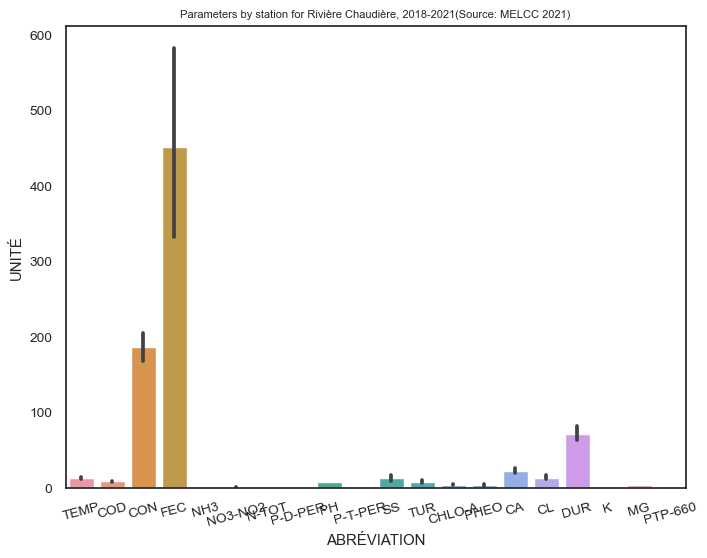

In [40]:
sns.barplot(data=ch1, 
             x="ABRÉVIATION", 
             y='UNITÉ'
            # hue="N° STATION"
           )
plt.title(label="Parameters by station for Rivière Chaudière, 2018-2021(Source: MELCC 2021)" ,
          fontdict={'fontsize':8}, loc='center')
plt.xticks(rotation=15)
plt.show()

In Chaudiere river, the concentration of fécaux ufc veried between 400 - 600 UFC/100 ml during 2018-2021

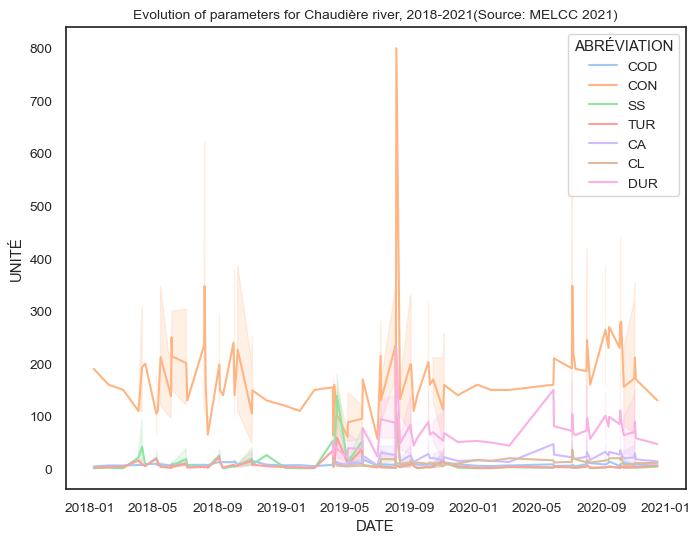

In [41]:
filtre=ch1.ABRÉVIATION.isin(['COD', 'CON', 'SS', 'TUR','CA', 'CL', 'DUR'])
plt.figure(figsize=(8,6))
sns.lineplot(data=ch1[filtre],
            y=ch1["UNITÉ"] , 
            x="DATE", 
            hue="ABRÉVIATION")
plt.title(label="Evolution of parameters for Chaudière river, 2018-2021(Source: MELCC 2021)",
          fontdict={'fontsize':10}, loc='center')
#plt.xticks(rotation=35)
plt.show()

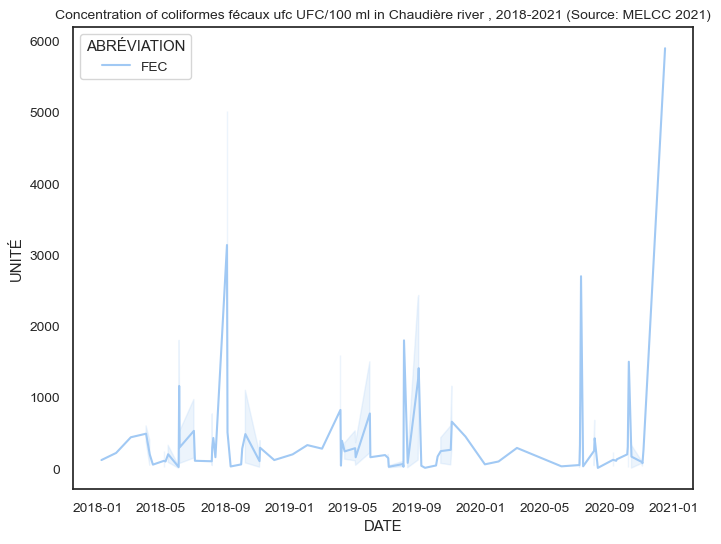

In [43]:
filtre=ch1.ABRÉVIATION.isin(['FEC'])
plt.figure(figsize=(8,6))
sns.lineplot(data=ch1[filtre],
            y=ch1["UNITÉ"] , 
            x="DATE", 
            hue="ABRÉVIATION")
plt.title(label="Concentration of coliformes fécaux ufc UFC/100 ml in Chaudière river , 2018-2021 (Source: MELCC 2021)",
          fontdict={'fontsize':10}, loc='center')
#plt.xticks(rotation=35)
plt.show()

In [44]:
df.columns

Index(['OBJECTID_x', 'NO_STATION', 'NomCoursEau', 'DESCRIPT', 'TYP_STAT',
       'TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE', 'geometry_x',
       'OBJECTID_y', 'SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT', 'Shape_Length', 'Shape_Area',
       'geometry_y'],
      dtype='object')

#### IQBP_CLASS

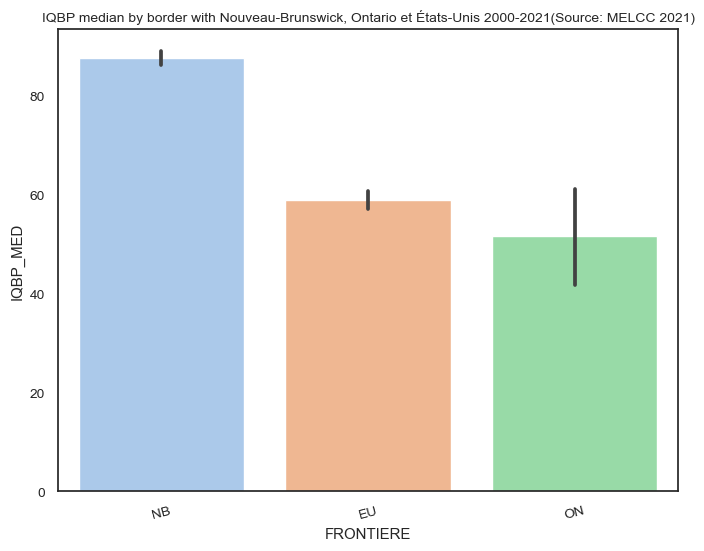

In [45]:
sns.barplot(data=df, 
             x="FRONTIERE", 
             y='IQBP_MED'
            # hue="N° STATION"
           )
plt.title(label="IQBP median by border with Nouveau-Brunswick, Ontario et États-Unis 2000-2021(Source: MELCC 2021)" ,
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=15)
plt.show()

At border with Nouveau-Brunswick,we have a bether quality of median value of the bacteriological quality index and 
physicochemical of water.

## NaN Values

In [46]:
df.shape

(5998, 53)

In [47]:
(df.isna().sum()/df.shape[0])*100

OBJECTID_x                0.000000
NO_STATION                0.000000
NomCoursEau               0.000000
DESCRIPT                  0.000000
TYP_STAT                  0.000000
TYP_SUIV                  0.000000
STAT_DEB                  0.000000
STAT_FIN                  0.000000
IQBP_N                    0.000000
IQBP_MED                  0.000000
IQBP_CLASS                0.000000
NH3_N                     0.700233
NH3_MED                   0.700233
NH3_Q90                   0.700233
CHLA_N                    1.700567
CHLA_MED                  1.700567
CHLA_Q90                  1.700567
CF_N                      0.716906
CF_MED                    0.716906
CF_Q90                    0.750250
MES_N                     0.700233
MES_MED                   0.700233
MES_Q90                   0.700233
NOX_N                     0.700233
NOX_MED                   0.700233
NOX_Q90                   0.700233
PTOT_N                   30.193398
PTOT_MED                 30.193398
PTOT_Q90            

* The FRONTIERE has 87% null value. We gone make a Yes/Non indicator: Yes, is a frontier other wise Non

* For the variable PC_AGRICOLE ,PC_FORESTIER , PC_HUMIDE,PC_AQUATIQUE ,PC_ANTHROPIQUE ,PC_COUPE_REGENERATION ,PC_SOL_NU_LANDE   ,PC_NON_CLASSIFIE we gone use 0.

The target variable is **IQBP_CLASS**  

In [172]:
df_mode=df.copy()

In [173]:
df_mode["PC_AGRICOLE"].fillna(0, inplace = True)
df_mode["PC_FORESTIER"].fillna(0, inplace = True)
df_mode["PC_HUMIDE"].fillna(0, inplace = True)
df_mode["PC_AQUATIQUE"].fillna(0, inplace = True)
df_mode["PC_ANTHROPIQUE"].fillna(0, inplace = True)
df_mode["PC_COUPE_REGENERATION"].fillna(0, inplace = True)
df_mode["PC_SOL_NU_LANDE"].fillna(0, inplace = True)
df_mode["PC_NON_CLASSIFIE"].fillna(0, inplace = True)

In [174]:
df_mode["FRONTIERE"].fillna("0", inplace = True)
df_mode.loc[(df_mode.FRONTIERE =="NB"), 'FRONTIERE'] = "1"
df_mode.loc[(df_mode.FRONTIERE =="EU"), 'FRONTIERE'] = "1"
df_mode.loc[(df_mode.FRONTIERE =="ON"), 'FRONTIERE'] = "1"

In [175]:
df_mode.FRONTIERE.unique()

array(['0', '1'], dtype=object)

In [176]:
df_mode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5998 entries, 0 to 5997
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID_x             5998 non-null   int64   
 1   NO_STATION             5998 non-null   object  
 2   NomCoursEau            5998 non-null   object  
 3   DESCRIPT               5998 non-null   object  
 4   TYP_STAT               5998 non-null   object  
 5   TYP_SUIV               5998 non-null   object  
 6   STAT_DEB               5998 non-null   object  
 7   STAT_FIN               5998 non-null   object  
 8   IQBP_N                 5998 non-null   int64   
 9   IQBP_MED               5998 non-null   int64   
 10  IQBP_CLASS             5998 non-null   int64   
 11  NH3_N                  5956 non-null   float64 
 12  NH3_MED                5956 non-null   float64 
 13  NH3_Q90                5956 non-null   float64 
 14  CHLA_N                 5896 non-

In [177]:
df_mode.drop(['OBJECTID_x', 'IQBP_N', 'NO_STATION',"DESCRIPT","TYP_STAT","TYP_SUIV","STAT_DEB","STAT_FIN","URL_ZGIEBV","URL_ZGIESL",
             "LAT","LONG","NOM_ZGIEBV","NOM_ZGIESL","geometry_x","OBJECTID_y","ANNEE_UT","Shape_Length","Shape_Area","geometry_y"], axis=1,inplace=True)

In [178]:
df_mode.drop(["PC_SOL_NU_LANDE"],axis=1,inplace=True)

In [179]:
df_mode.drop(['NH3_N',"NH3_Q90","CHLA_N","CHLA_Q90","CF_N","CF_Q90","MES_N","MES_Q90","NOX_N","NOX_Q90",
             "PTOT_N","PTOT_Q90"],axis=1,inplace=True)

In [180]:
df_mode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5998 entries, 0 to 5997
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NomCoursEau            5998 non-null   object 
 1   IQBP_MED               5998 non-null   int64  
 2   IQBP_CLASS             5998 non-null   int64  
 3   NH3_MED                5956 non-null   float64
 4   CHLA_MED               5896 non-null   float64
 5   CF_MED                 5955 non-null   float64
 6   MES_MED                5956 non-null   float64
 7   NOX_MED                5956 non-null   float64
 8   PTOT_MED               4187 non-null   float64
 9   ANNEE_FILTRE           5998 non-null   object 
 10  SUPERF_QC_KM2          4457 non-null   float64
 11  SUPERF_TOT_KM2         4457 non-null   float64
 12  FRONTIERE              5998 non-null   object 
 13  PC_AGRICOLE            5998 non-null   float64
 14  PC_FORESTIER           5998 non-null   float64
 

In [181]:
df_mode.dropna(axis=0,inplace=True)

In [182]:
df_mode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3191 entries, 39 to 5997
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NomCoursEau            3191 non-null   object 
 1   IQBP_MED               3191 non-null   int64  
 2   IQBP_CLASS             3191 non-null   int64  
 3   NH3_MED                3191 non-null   float64
 4   CHLA_MED               3191 non-null   float64
 5   CF_MED                 3191 non-null   float64
 6   MES_MED                3191 non-null   float64
 7   NOX_MED                3191 non-null   float64
 8   PTOT_MED               3191 non-null   float64
 9   ANNEE_FILTRE           3191 non-null   object 
 10  SUPERF_QC_KM2          3191 non-null   float64
 11  SUPERF_TOT_KM2         3191 non-null   float64
 12  FRONTIERE              3191 non-null   object 
 13  PC_AGRICOLE            3191 non-null   float64
 14  PC_FORESTIER           3191 non-null   float64


## Correlation matrix

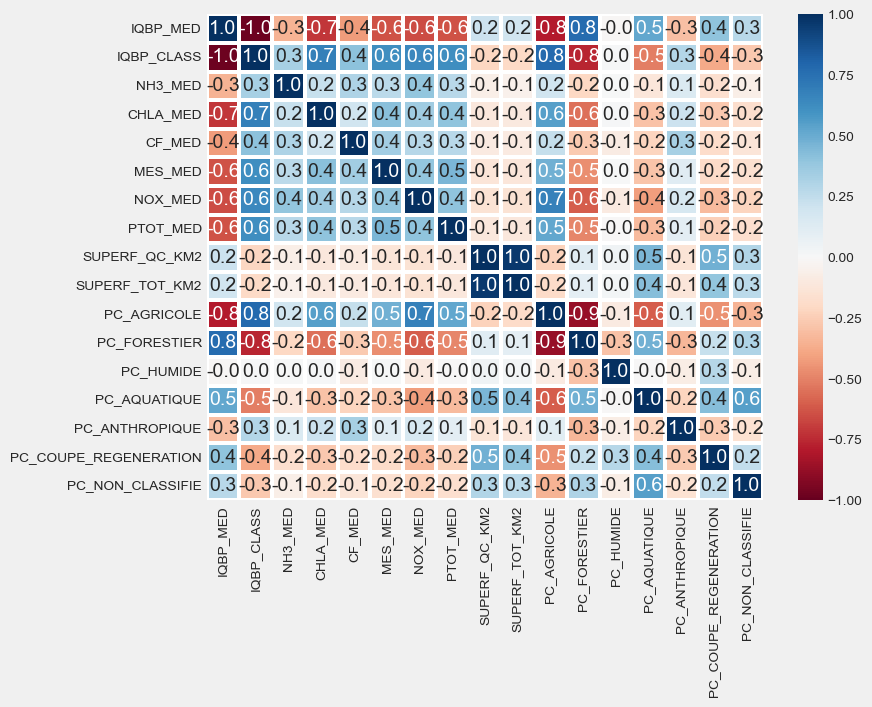

In [183]:
sns.heatmap(df_mode.corr(), 
           cmap='RdBu',#separer en negative/positive correlation
           center=0,
           vmin=-1,# specifier l'interval[-1,1]
           vmax=1,
            annot=True,
           fmt='.1f'# format des numbers 2 digits after .
            ,linewidths=1.5)
plt.show()

There is a negative correlation between IQBP_MED and CHLA_MED, CF_MED, MES_MED and PC_AGRICOLE. So the quality of water decrease if there is a concentration of substance and the presence of agricol land.

Positive correlation with PC_FORESTIER, which means that the quality of water increase with the presence of the forest.

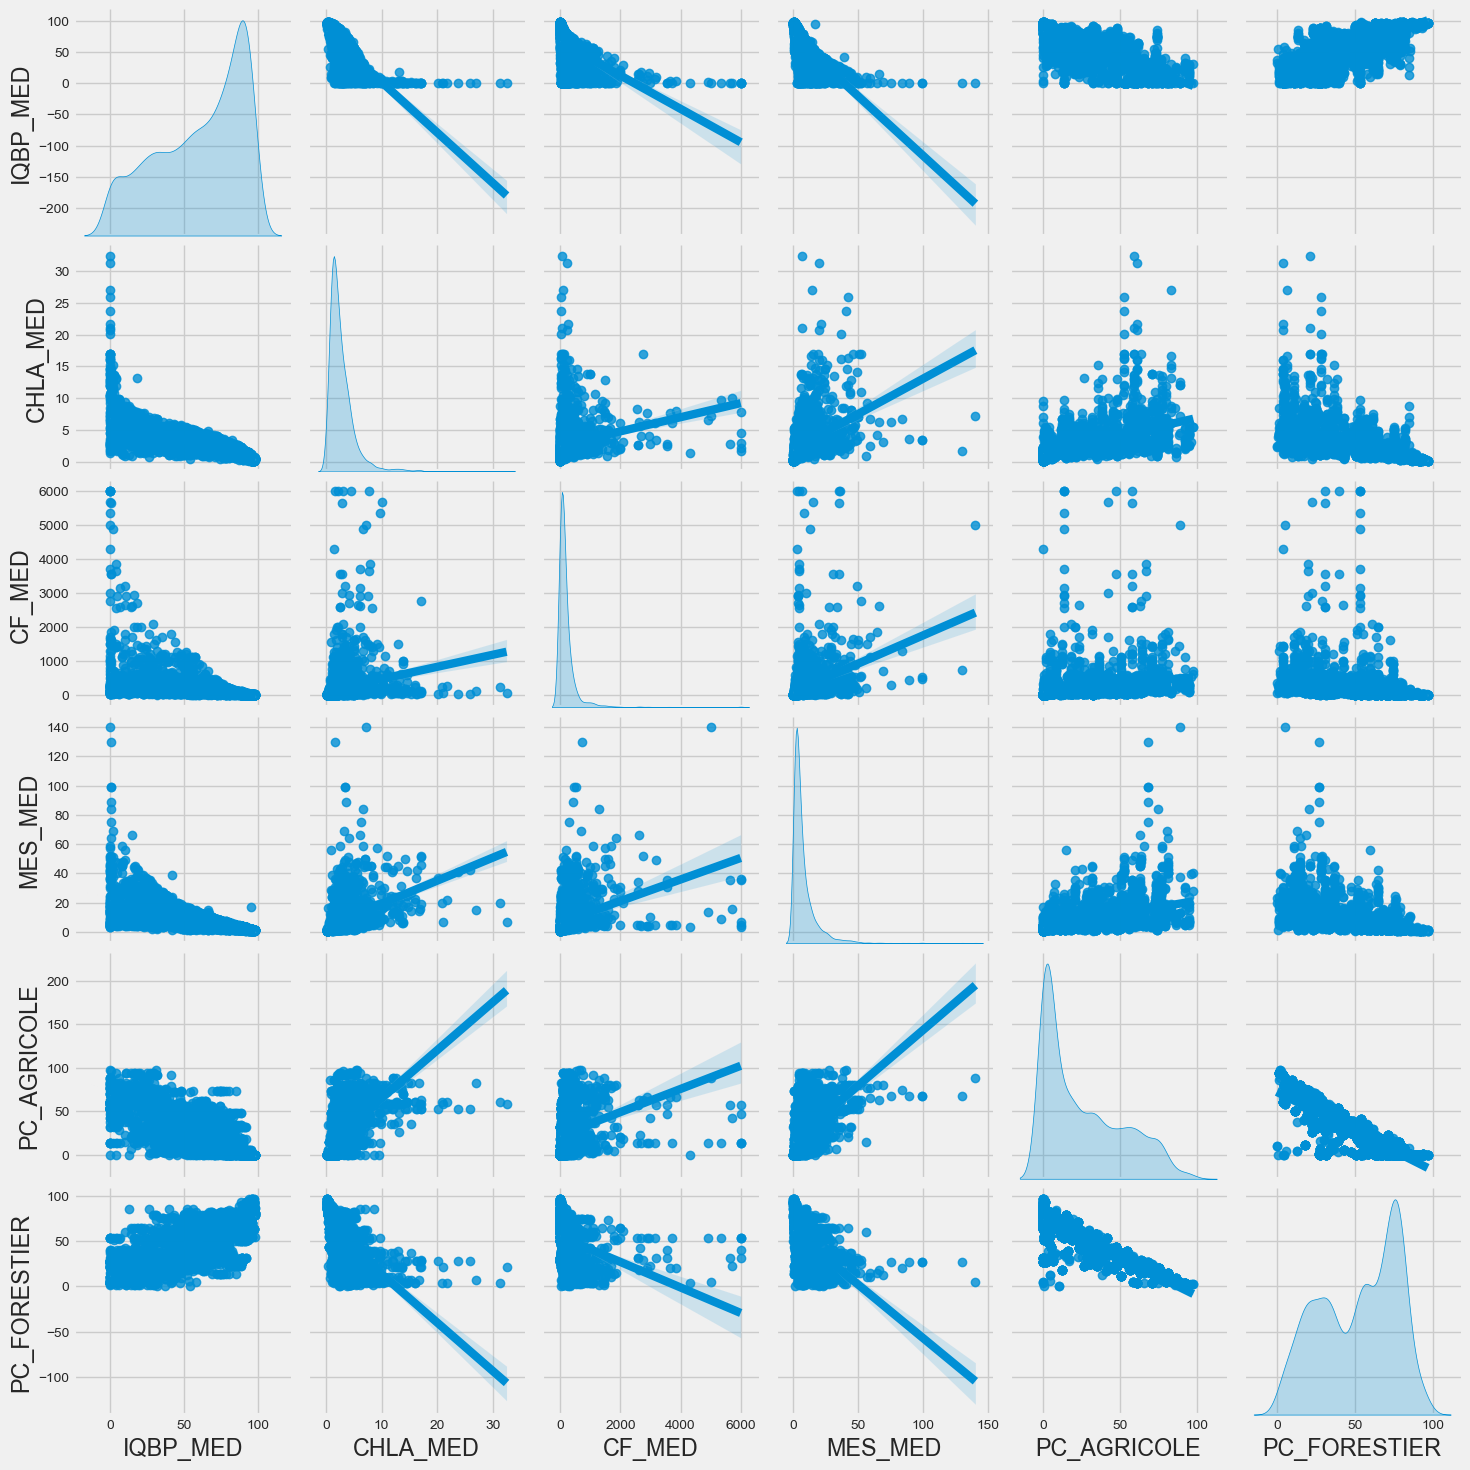

In [184]:
sns.pairplot(data=df_mode[["IQBP_MED","CHLA_MED", "CF_MED", "MES_MED","PC_AGRICOLE","PC_FORESTIER"]],
            diag_kind='kde',#changer le type de diagramme sur la diagonale
            kind='reg' # regplot diagonale 
            ,palette='plasma'
            )
plt.show()

## Separation of variables X and target y from the database.

In [185]:
# Caractéristiques mesurées
X = df_mode.drop(['IQBP_CLASS'], axis=1)

# Réponse binaire
y = df_mode["IQBP_CLASS"]



In [186]:
X.columns

Index(['NomCoursEau', 'IQBP_MED', 'NH3_MED', 'CHLA_MED', 'CF_MED', 'MES_MED',
       'NOX_MED', 'PTOT_MED', 'ANNEE_FILTRE', 'SUPERF_QC_KM2',
       'SUPERF_TOT_KM2', 'FRONTIERE', 'PC_AGRICOLE', 'PC_FORESTIER',
       'PC_HUMIDE', 'PC_AQUATIQUE', 'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION',
       'PC_NON_CLASSIFIE'],
      dtype='object')

## Separation of data into training (80%) and test (20%) sets.

Separate the dataset into a training set (which will be used to train a regression algorithm) and a test set (which will measure performance on data never encountered).

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [248]:
y_train_=pd.DataFrame(y_train,columns=["IQBP_CLASS"])
y_test_=pd.DataFrame(y_test,columns=["IQBP_CLASS"])

In [249]:
X_train.columns

Index(['NomCoursEau', 'IQBP_MED', 'NH3_MED', 'CHLA_MED', 'CF_MED', 'MES_MED',
       'NOX_MED', 'PTOT_MED', 'ANNEE_FILTRE', 'SUPERF_QC_KM2',
       'SUPERF_TOT_KM2', 'FRONTIERE', 'PC_AGRICOLE', 'PC_FORESTIER',
       'PC_HUMIDE', 'PC_AQUATIQUE', 'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION',
       'PC_NON_CLASSIFIE'],
      dtype='object')

In [250]:
X_train.shape

(2552, 19)

In [251]:
y_train_.shape

(2552, 1)

### Standard scale

In [252]:
X_=X_train.copy()
cours_eau=X_train.NomCoursEau
X_train=X_train.drop(['NomCoursEau','ANNEE_FILTRE','IQBP_MED'],axis=1)
X_test=X_test.drop(['NomCoursEau','ANNEE_FILTRE','IQBP_MED'],axis=1)
# Liste des variables utilisées
feature_list = list(X_train.columns)

In [253]:
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

In [254]:
X_train_std.round(3)

array([[-0.344, -0.123, -0.215, ..., -0.564,  2.145, -0.529],
       [-0.344, -0.521, -0.283, ..., -0.34 , -0.023,  0.665],
       [ 1.816,  0.212,  0.159, ...,  0.763, -0.555,  0.267],
       ...,
       [ 0.401,  0.271,  2.6  , ...,  1.637, -0.428, -0.131],
       [-0.344, -0.115, -0.079, ...,  1.266, -0.044,  0.267],
       [-0.344, -0.732, -0.46 , ..., -0.645,  0.832,  1.461]])

In [255]:
# convertir en dataframe

X_train_std_= pd.DataFrame({"NomCoursEau":cours_eau,
                       #'IQBP_N':X_train_std.T[0],
                       #'IQBP_MED':X_train_std.T[0],
                       'NH3_MED':X_train_std.T[0], 
                       'CHLA_MED':X_train_std.T[1],
                       'CF_MED':X_train_std.T[2],
                       'MES_MED':X_train_std.T[3],
                       'NOX_MED':X_train_std.T[4],
                       'PTOT_MED':X_train_std.T[5],
                       'SUPERF_QC_KM2':X_train_std.T[6], 
                       'SUPERF_TOT_KM2':X_train_std.T[7],
                       "FRONTIERE":X_train_std.T[8],
                       'PC_AGRICOLE':X_train_std.T[9],  
                       'PC_FORESTIER':X_train_std.T[10],
                       'PC_HUMIDE':X_train_std.T[11], 
                       'PC_AQUATIQUE':X_train_std.T[12], 
                       'PC_ANTHROPIQUE':X_train_std.T[13], 
                       'PC_COUPE_REGENERATION':X_train_std.T[14],
                       'PC_NON_CLASSIFIE' :X_train_std.T[15]         
                      })
X_train_std_

NomCoursEau   NH3_MED  CHLA_MED    CF_MED   MES_MED   NOX_MED  \
4458    Rivière à la Loutre -0.343606 -0.123111 -0.215210  1.458668 -0.600366   
5257        Rivière Blanche -0.343606 -0.521245 -0.283325 -0.603236 -0.578559   
4890   Rivière de l'Achigan  1.816167  0.211953  0.159423  0.633906  0.871650   
5131          Rivière Trout -0.343606 -0.755790 -0.181153 -0.706332 -0.371386   
5184        Rivière Delisle  1.890642  2.208537 -0.333276  0.530811  0.762612   
...                     ...       ...       ...       ...       ...       ...   
3441     Rivière Shawinigan  1.890642 -0.328091 -0.044922 -0.500141 -0.551299   
3483   Rivière L'Assomption  0.401143  0.253343  0.102660  0.427716 -0.164213   
3696   Rivière Yamaska Nord  0.401143  0.271081  2.600212 -0.345498  0.871650   
3136  Rivière Saint-Charles -0.343606 -0.115227 -0.078980 -0.603236 -0.376838   
5979   Rivière aux Outardes -0.343606 -0.732138 -0.460424 -0.706332 -0.578559   

      PTOT_MED  SUPERF_QC_KM2  SUPERF_TOT_KM2  FRONTIERE  PC_AGRICOLE  \
4458  0.007435      -0.274142       -0.272546  -0.409181    -0.289720   
5257 -0.474956      -0.288226       -0.284555  -0.409181    -0.920539   
4890  0.184312      -0.239784       -0.243250  -0.409181    -0.008791   
5131 -0.426717      -0.288680       -0.261688   2.443906     1.897378   
5184  0.634543      -0.281332       -0.261317   2.443906     2.242173   
...        ...            ...             ...        ...          ...   
3441  0.087834      -0.253233       -0.254717  -0.409181    -0.897030   
3483 -0.040804      -0.176394       -0.189200  -0.409181    -0.755586   
3696  0.441587      -0.273514       -0.272011  -0.409181    -0.090288   
3136 -0.523195      -0.265600       -0.265263  -0.409181    -0.938170   
5979 -0.619674       1.355148        1.116684  -0.409181    -0.993808   

      PC_FORESTIER  PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
4458      0.246837  -0.248368      0.007713       -0.563926   
5257      0.914049   0.072597      0.887659       -0.340144   
4890     -0.030120  -0.305137      0.051033        0.763333   
5131     -1.568811  -0.295312     -0.758517       -0.185811   
5184     -1.839269  -0.816061     -0.761224        0.153720   
...            ...        ...           ...             ...   
3441      1.087858  -0.483087      1.312741       -0.315708   
3483      0.951816  -0.733090      0.522143        0.089415   
3696     -0.389919   0.066046      0.126844        1.636598   
3136      0.765419  -0.411034     -0.146616        1.266200   
5979      0.595671  -0.137013      2.547373       -0.644950   

      PC_COUPE_REGENERATION  PC_NON_CLASSIFIE  
4458               2.144858         -0.528891  
5257              -0.022840          0.664856  
4890              -0.554839          0.266940  
5131              -0.673943         -0.528891  
5184              -0.673943         -0.528891  
...                     ...               ...  
3441              -0.433088          1.062772  
3483               0.011568          0.664856  
3696              -0.427794         -0.130975  
3136              -0.044014          0.266940  
5979               0.832064          1.460688  

[2552 rows x 17 columns]

This table of centered-reduced data already gives some information: we see for example that Rivière Delisle, have a CHLA_MED,  of 2.20 . This means that the some parameters of this river are extreme. The value of +2 means that these are above average values and quite extreme.

### PCA

In [256]:
#instanciation
pca = PCA(svd_solver='full')
#affichage des paramètres
print(pca)


PCA(svd_solver='full')


In [257]:
X_result=pca.fit_transform(X_train_std)
X_result.shape

(2552, 16)

In [258]:
print(pca.components_)
print("\n Le plan défini par les premiers deux composantes principales (uj): "+'\n',pca.components_.T[:,:2])

[[ 1.71849197e-01  2.82944931e-01  2.03398661e-01  2.68711960e-01
   3.15558593e-01  2.80351925e-01 -2.13572806e-01 -1.98517676e-01
   2.00457559e-02  3.83063739e-01 -3.50075784e-01 -1.57149969e-02
  -3.21996833e-01  1.65713386e-01 -2.59181018e-01 -2.13022266e-01]
 [ 1.60750208e-01  1.89283694e-01  1.11189771e-01  1.89616515e-01
   1.57588680e-01  1.95737647e-01  5.52830918e-01  5.47378273e-01
   5.62604126e-02  1.29082811e-01 -2.42113651e-01  1.19205268e-01
   1.89341084e-01 -2.06312009e-02  2.52221103e-01  1.70509089e-01]
 [ 2.86506452e-01 -1.87173758e-02  3.78190567e-01  5.13281012e-02
   6.58225865e-02  2.21439707e-02  3.48614086e-02  4.24074095e-02
  -1.93484561e-03 -1.35099111e-01  2.89173696e-01 -6.24099008e-01
   1.86984991e-01  2.95537279e-01 -2.65668049e-01  2.82493655e-01]
 [ 2.15864712e-01 -6.91761924e-02  3.25580547e-01  1.87330078e-01
   5.02482165e-02 -6.87484870e-02 -8.91680246e-02 -1.64855111e-01
  -6.78604537e-01 -2.44073200e-01  1.17170249e-02  3.38926987e-01
   5.03

In [259]:
pca.explained_variance_ratio_

array([3.12523535e-01, 1.33276152e-01, 8.47786876e-02, 8.02096332e-02,
       6.51727842e-02, 5.74005638e-02, 5.26974036e-02, 4.81835874e-02,
       3.79923494e-02, 3.23447200e-02, 2.87655554e-02, 2.71650780e-02,
       2.28525891e-02, 1.48717550e-02, 1.73157452e-03, 3.40322174e-05])

In [260]:
n=X_result.shape[0]
eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[5.00037656e+00 2.13241843e+00 1.35645900e+00 1.28335413e+00
 1.04276455e+00 9.18409021e-01 8.43158458e-01 7.70937398e-01
 6.07877591e-01 5.17515520e-01 4.60248887e-01 4.34641249e-01
 3.65641426e-01 2.37948079e-01 2.77051923e-02 5.44515478e-04]


In [261]:
pve=pd.DataFrame({"Composante principale":range(1,pca.n_components_+1),"Eigen value":eigval,
                  "Proportion(%)":np.round(pca.explained_variance_ratio_*100,2)})
pve['Cumulative(%)']=np.cumsum(pve['Proportion(%)'])
pve.set_index("Composante principale")

Eigen value  Proportion(%)  Cumulative(%)
Composante principale                                           
1                         5.000377          31.25          31.25
2                         2.132418          13.33          44.58
3                         1.356459           8.48          53.06
4                         1.283354           8.02          61.08
5                         1.042765           6.52          67.60
6                         0.918409           5.74          73.34
7                         0.843158           5.27          78.61
8                         0.770937           4.82          83.43
9                         0.607878           3.80          87.23
10                        0.517516           3.23          90.46
11                        0.460249           2.88          93.34
12                        0.434641           2.72          96.06
13                        0.365641           2.29          98.35
14                        0.237948           1.49          99.84
15                        0.027705           0.17         100.01
16                        0.000545           0.00         100.01

##### Critere de Kaise: garder les premiers valeurs propres superieur a 1.
Dans notre cas on a λ1 = 5.80 > 1 , λ2 = 2.195164, λ3 =1.366  λ4 =1.31  λ5 =1.05 λ6 =0.91 
proche de 1 donc on peut garder la 6 eme axe. 

In [262]:
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1
d

12

« Règle du coude » de Cattell: le nombre de facteurs K* à retenir

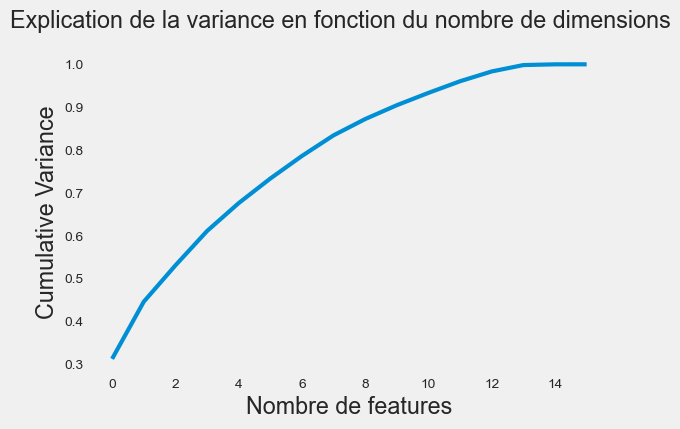

In [263]:
plt.figure(1, figsize=(6,4))
plt.suptitle("Explication de la variance en fonction du nombre de dimensions")
plt.plot(cumsum, linewidth= 3)
plt.axis('tight')
plt.grid()

plt.xlabel("Nombre de features")
plt.ylabel("Cumulative Variance")

plt.show()

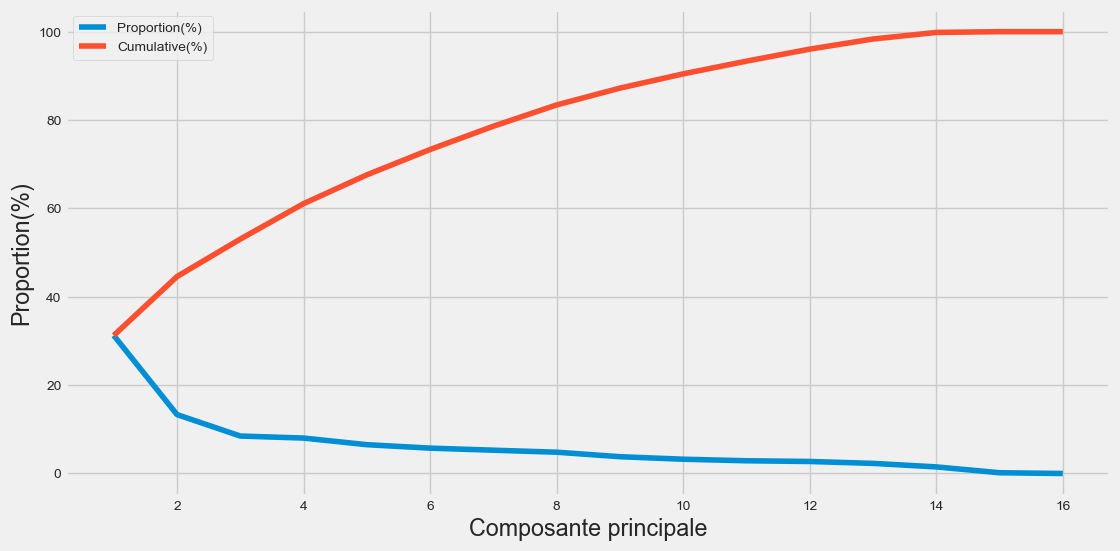

In [264]:
plt.figure(figsize=(12,6))
sns.lineplot(x="Composante principale",y='Proportion(%)',data=pve)
sns.lineplot(x="Composante principale",y='Cumulative(%)',data=pve)
plt.legend(['Proportion(%)',"Cumulative(%)"])
plt.show()

In [265]:
X_.set_index("NomCoursEau",inplace=True)

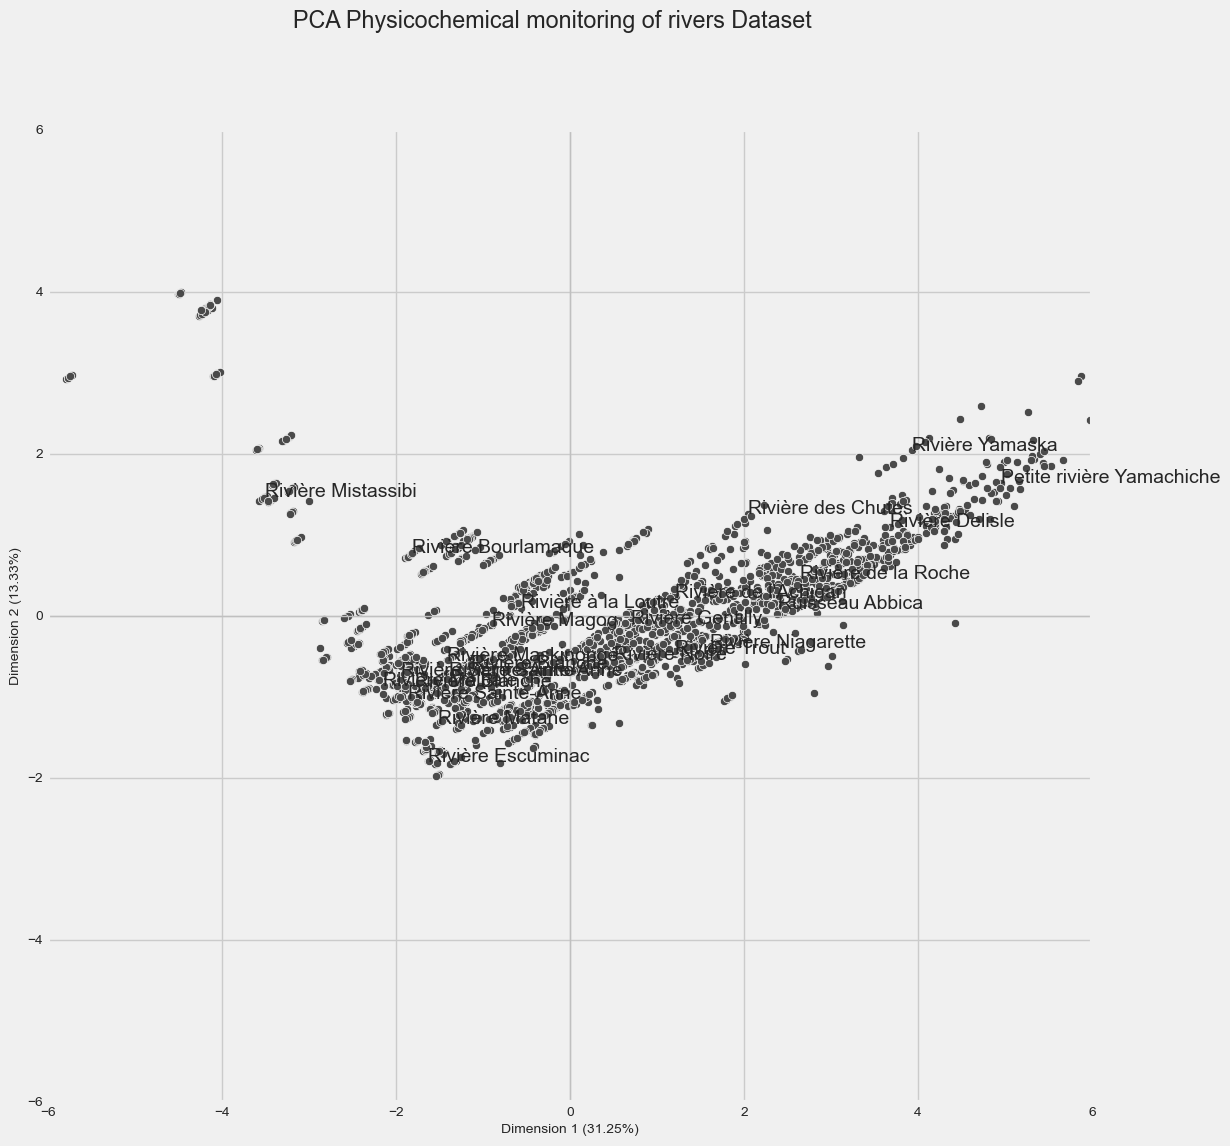

In [266]:
#plot comme scatter

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) #même limites en abscisse
axes.set_ylim(-6,6) #et en ordonnée

plt.suptitle("PCA Physicochemical monitoring of rivers Dataset")
#Les coordonnées factorielles (Fik) des individus
p1_values=X_result[:,0]
p2_values=X_result[:,1]

#placer les etiquettes 
for i in range(25):
    plt.annotate(X_.index[i],(X_result[i,0],X_result[i,1]))
sns.scatterplot(x=p1_values,y=p2_values,color=".29")

#ajouter les axes

plt.plot([-7,7],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-7,7],color='silver',linestyle='-',linewidth=1)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Dimension 1 (" + str(np.round(pca.explained_variance_ratio_[0]*100,2))+"%)", fontsize = 10) # x-axis label
plt.ylabel("Dimension 2 (" + str(np.round(pca.explained_variance_ratio_[1]*100,2))+"%)", fontsize = 10) # y-axis label
plt.show()

The best representation of individuals is as follows. T

his graph shows for example that Yamaska River and Chute rivier are very close. 
This means that the means of the variables are very close.
To interpret the axes, variables are needed. 
What pits Yamaska river against Misssibi river?

These 2 rivers are completely opposite, opposite on the first axis. So if they are opposite on the 1st axis, 
This means that they are very different rivers since the first axis is the one that separates the 
better points, so these two rivers have very different behaviors, and this, on all variables.

#### Contribution of an individual in total inertia

In [267]:
di=np.sum(X_train_std**2,axis=1)
print("***********La contribution d'un individu i dans l'inertie totale*********")
d_=pd.DataFrame({"ID":cours_eau,"di":di})
d_.set_index("ID")
d_.drop_duplicates()
print(d_.sort_values(by=["di"],axis=0,ascending=False))

***********La contribution d'un individu i dans l'inertie totale*********
                             ID           di
4711          Rivière des Vases  1061.143921
1668     Rivière de l'Esturgeon   579.053704
5064          Rivière des Vases   473.828747
1760            Ruisseau Bibeau   309.012940
4880  Cours d'eau sans toponyme   231.539981
...                         ...          ...
4494         Rivière des Envies     0.998137
3305          Rivière Chaudière     0.989489
4859         Rivière des Envies     0.984391
2831           Rivière Portneuf     0.976527
2552           Rivière Portneuf     0.902451

[2552 rows x 2 columns]


the Rivière des Vases and Rivière de l'Esturgeon are the two rivers that stand out the most, and they are found at both ends of the first factorial axis which carries 44% of the available information

#### Variable Analysis

In [268]:
print(len(pca.components_))

16


In [148]:
#pca.components_.T

In [269]:
corvar = np.zeros((16,16))
#corvar

In [270]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes

for k in range(6):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
#afficher la matrice des corrélations variables x facteurs 
#print(corvar)


In [271]:
X_train_std_.drop(['NomCoursEau'],axis=1,inplace=True)

In [272]:
corvar[:,0]

array([ 0.38428096,  0.63270792,  0.45483036,  0.60088083,  0.70563703,
        0.62690957, -0.47758129, -0.44391573,  0.04482536,  0.85658881,
       -0.78282273, -0.03514112, -0.72003392,  0.37056035, -0.5795682 ,
       -0.4763502 ])

In [273]:
#on affiche pour les deux premiers axes
print(pd.DataFrame({'id': X_train_std_.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

                       id     COR_1     COR_2
0                 NH3_MED  0.384281  0.234740
1                CHLA_MED  0.632708  0.276407
2                  CF_MED  0.454830  0.162368
3                 MES_MED  0.600881  0.276893
4                 NOX_MED  0.705637  0.230124
5                PTOT_MED  0.626910  0.285832
6           SUPERF_QC_KM2 -0.477581  0.807288
7          SUPERF_TOT_KM2 -0.443916  0.799326
8               FRONTIERE  0.044825  0.082156
9             PC_AGRICOLE  0.856589  0.188497
10           PC_FORESTIER -0.782823 -0.353554
11              PC_HUMIDE -0.035141  0.174073
12           PC_AQUATIQUE -0.720034  0.276491
13         PC_ANTHROPIQUE  0.370560 -0.030127
14  PC_COUPE_REGENERATION -0.579568  0.368313
15       PC_NON_CLASSIFIE -0.476350  0.248991


#### Correlation circle

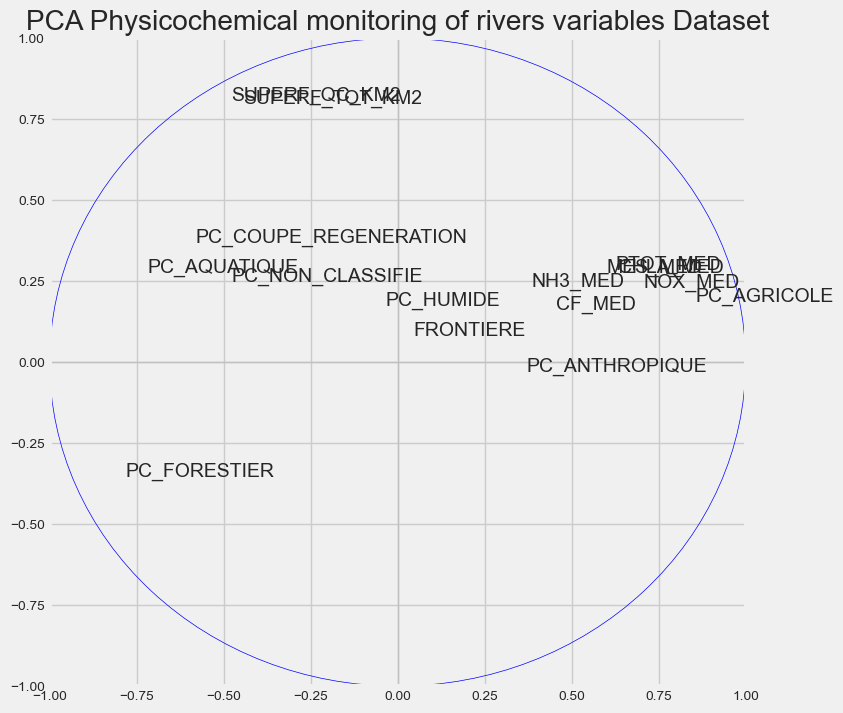

In [274]:
#cercle des corrélations

fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(X_train_std_.shape[1]):
    plt.annotate(X_train_std_.columns[j],(corvar[j,0],corvar[j,1]))
 
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
plt.title("PCA Physicochemical monitoring of rivers variables Dataset")
#affichage
plt.show()

For the example, the graph of the correlation circle is as follows: we see that the PC_AGRICOLE,NOX_MED,NH3_MED,CF_MED variables 
are correlated to axis 1, factor 1. 

That is, THE RIVERS that are on the left, with a weak coordinate on axis 1 have low values in PARAMETERS,
rivers that are in the middle 
have medium values in PARAMETERS and rivers that are on the right have values in PARAMETERS
high, compared to other rivers.

### Handling Imbalanced Data with SMOTE

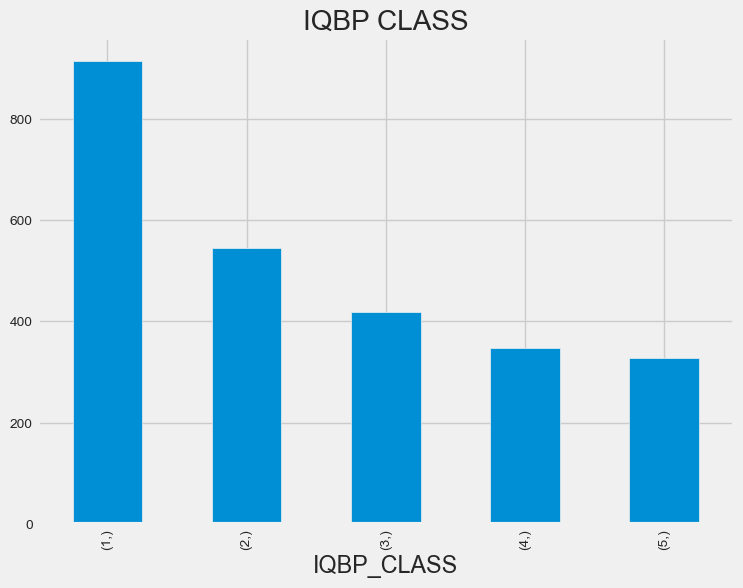

In [275]:
y_train_.value_counts().plot(kind='bar').set_title('IQBP CLASS');

In [217]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train_std, y_train_)

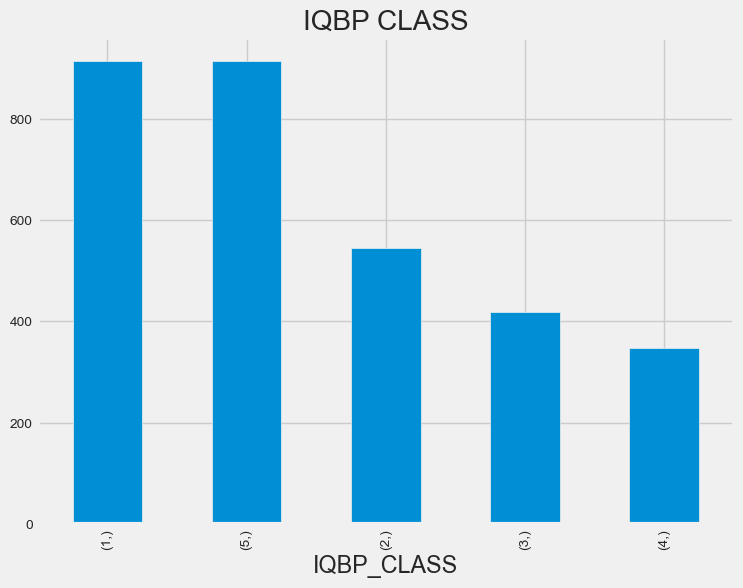

In [218]:
y_sm.value_counts().plot(kind='bar').set_title('IQBP CLASS');

In [219]:
y_train_.shape

(2552, 1)

In [220]:
y_sm.shape

(3139, 1)

## Partie II: Entrainement d'un classifieur.

In [276]:
# Sélection
rf = RandomForestClassifier()

# Entrainement du modèle
model = rf.fit(X_train_std, y_train)

In [277]:
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

#### Viewing the classification statistics report.

In [278]:
print(
    "Exactitude sur les données d'entrainement: %0.1f %%"
    % (100 * accuracy_score(y_train, y_pred_train))
)

print(
    "Exactitude sur les données de test: %0.1f %%\n\n"
    % (100 * accuracy_score(y_test, y_pred_test))
)

Exactitude sur les données d'entrainement: 100.0 %
Exactitude sur les données de test: 86.2 %




In [279]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97       235
           2       0.85      0.84      0.85       131
           3       0.75      0.75      0.75       107
           4       0.75      0.74      0.75        94
           5       0.85      0.85      0.85        72

    accuracy                           0.86       639
   macro avg       0.83      0.83      0.83       639
weighted avg       0.86      0.86      0.86       639



The 100% accuracy for the training data shows that the classifier has memorized response y for each characteristic X. This is the problem of overfitting. 
Moreover, the big difference between the two results (86 % <i>versus</i> 100 %) is an indicator of overfitting.

## Part III: Optimization of classifier hyperparameters

In [289]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
}

In [290]:
from sklearn.model_selection import train_test_split, GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
)

In [291]:
grid_search.fit(X_train_std, y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [292]:
# Prédiction des réponses y pour chaque ensemble
y_pred_train = grid_search.predict(X_train_std)
y_pred_test = grid_search.predict(X_test_std)


In [293]:
print(
    "Exactitude sur les données d'entrainement: %0.1f %%"
    % (100 * accuracy_score(y_train, y_pred_train))
)

print(
    "Exactitude sur les données de test: %0.1f %%\n\n"
    % (100 * accuracy_score(y_test, y_pred_test))
)

Exactitude sur les données d'entrainement: 86.3 %
Exactitude sur les données de test: 81.2 %




There is no more overfitting since the two accuracy values are now similar and 
less than 100%! 

In [296]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96       235
           2       0.72      0.87      0.79       131
           3       0.68      0.57      0.62       107
           4       0.70      0.68      0.69        94
           5       0.84      0.75      0.79        72

    accuracy                           0.81       639
   macro avg       0.78      0.77      0.77       639
weighted avg       0.81      0.81      0.81       639



The first column contains the digits 0 ,1,2,3,4,5; 
This identifies the results for rivers that are classified between 0 (very poor quality) and 5(very good quality). 

The recall is the proportion of rivers detected in the right class. WE have 96% of score in the chall 1 and a poor classification rate in the class 3 ans 4

## Part IV: Identification of the most important variables

In [300]:
rf = RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=300)
model = rf.fit(X_train_std, y_train)

In [301]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96       235
           2       0.72      0.87      0.79       131
           3       0.68      0.57      0.62       107
           4       0.70      0.68      0.69        94
           5       0.84      0.75      0.79        72

    accuracy                           0.81       639
   macro avg       0.78      0.77      0.77       639
weighted avg       0.81      0.81      0.81       639



In [302]:
feature_list

['NH3_MED',
 'CHLA_MED',
 'CF_MED',
 'MES_MED',
 'NOX_MED',
 'PTOT_MED',
 'SUPERF_QC_KM2',
 'SUPERF_TOT_KM2',
 'FRONTIERE',
 'PC_AGRICOLE',
 'PC_FORESTIER',
 'PC_HUMIDE',
 'PC_AQUATIQUE',
 'PC_ANTHROPIQUE',
 'PC_COUPE_REGENERATION',
 'PC_NON_CLASSIFIE']

In [303]:
importances = list(model.feature_importances_)

# Le nom de chaque variable est associé à son importance.
feature_importances = [(feature, round(importance, 2)) for feature, importance
                       in zip(feature_list, importances)]

# Ordonnancement des valeurs d'importance en ordre décroissant.
feature_importances = sorted(feature_importances, key=lambda x: x[1],
                             reverse=True)

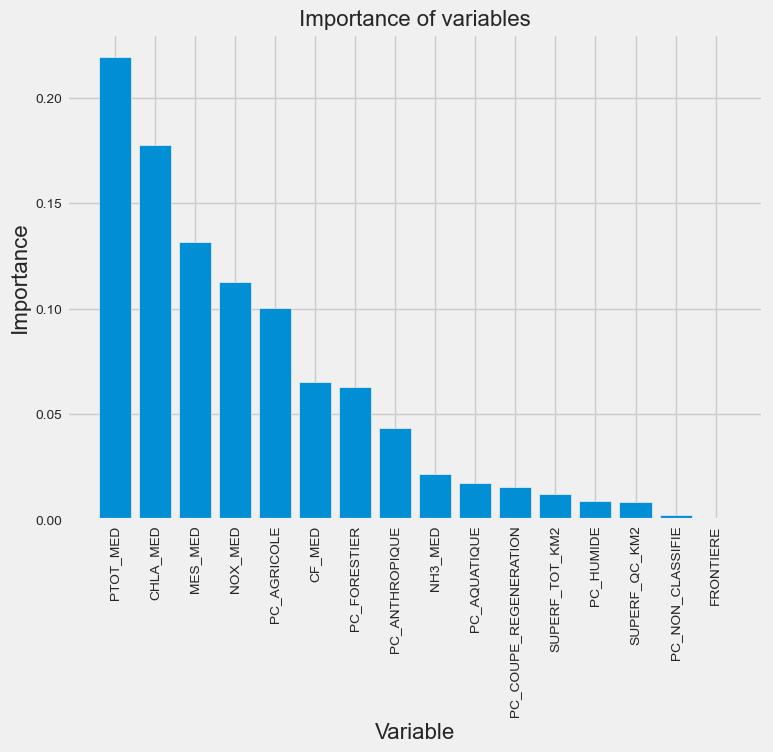

In [304]:
indices = np.argsort(importances)[::-1]

plt.style.use('fivethirtyeight')

var = list(range(len(importances)))
plt.bar(var, np.array(importances)[indices.astype(int)],
        orientation='vertical')
plt.xticks(var, np.array(feature_list)[indices.astype(int)],
           rotation='vertical')
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Variable', fontsize=16)
plt.title('Importance of variables', fontsize=16);

 Note that the two most important variables are:
 
 <ul>
<li>PTOT_MED,</li>
<li>CHLA_MED</li>
<li>MES_MED</li>
</ul>

The following four variables have a real but lesser effect:

 <ul>
<li>NOX_MED,</li>
<li>PC_AGRICOLE</li>
<li>CF_MED</li>
<li>PC_FORESTIER</li>    
</ul>

The last two, SUPERF_QC_KM2 and the FRONTIERE, have a negligible effect on 
the likelihood of bad water.
